## 1. Setup and Imports

In [1]:
!pip install neo4j pandas numpy matplotlib seaborn

In [15]:
from neo4j import GraphDatabase
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### Connect to Neo4j

**⚠️ Update the password below to match your Neo4j instance!**

In [18]:
# Neo4j connection parameters
NEO4J_URI = "bolt://localhost:7687"
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = "JeanAlice#123"  # CHANGE THIS!

# Test connection
driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

try:
    with driver.session() as session:
        result = session.run("RETURN 'Connected to Neo4j!' AS message")
        print(result.single()["message"])
        print("✓ Connection successful!")
except Exception as e:
    print(f"✗ Connection failed: {e}")
    print("Make sure Neo4j is running: docker ps or using local command(To be specify) if not working with docker")

Connected to Neo4j!
✓ Connection successful!


## 2. Understanding the dataset

In [19]:
# Load the CSV files
data_path =''
movies_df = pd.read_csv(os.path.join(data_path, "movies.csv"))
ratings_df = pd.read_csv(os.path.join(data_path, "ratings.csv"))

print("="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"Number of users: {ratings_df['userId'].nunique():,}")
print(f"Number of movies: {movies_df.shape[0]:,}")
print(f"Number of ratings: {ratings_df.shape[0]:,}")
print(f"\nRating range: {ratings_df['rating'].min()} - {ratings_df['rating'].max()}")
print(f"Average rating: {ratings_df['rating'].mean():.2f}")
print(f"Median rating: {ratings_df['rating'].median():.1f}")

DATASET OVERVIEW
Number of users: 671
Number of movies: 9,125
Number of ratings: 100,004

Rating range: 0.5 - 5.0
Average rating: 3.54
Median rating: 4.0


In [5]:
# Preview the data
print("\n" + "="*60)
print("MOVIES SAMPLE")
print("="*60)
display(movies_df.head(10))

print("\n" + "="*60)
print("RATINGS SAMPLE")
print("="*60)
display(ratings_df.head(10))


MOVIES SAMPLE


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller



RATINGS SAMPLE


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


## 3.Exploratory data analysis

We have 9125 movies
Number of duplicated movies :0
Number of missing values in the movies data :
movieId    0
title      0
genres     0
dtype: int64
Distribution of the movies genres
Total Numbers of genres : 20
genres_list
Drama                 4365
Comedy                3315
Thriller              1729
Action                1545
Romance               1545
Adventure             1117
Crime                 1100
Horror                 877
Sci-Fi                 792
Fantasy                654
Children               583
Mystery                543
Documentary            495
Animation              447
Musical                394
War                    367
Western                168
IMAX                   153
Film-Noir              133
(no genres listed)      18
Name: count, dtype: int64
Multigenders movies
   n_genres  percentage
7         1       30.61
8         2       33.30
6         3       23.18
5         4        9.34
4         5        2.86
3         6        0.55
2         7        0.1

/tmp/ipykernel_80625/4034258553.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y = 'genre', x = 'count', data = genre_df, palette = 'crest')
/tmp/ipykernel_80625/4034258553.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='n_genres', y = 'percentage', data = dist_df, palette = 'viridis')


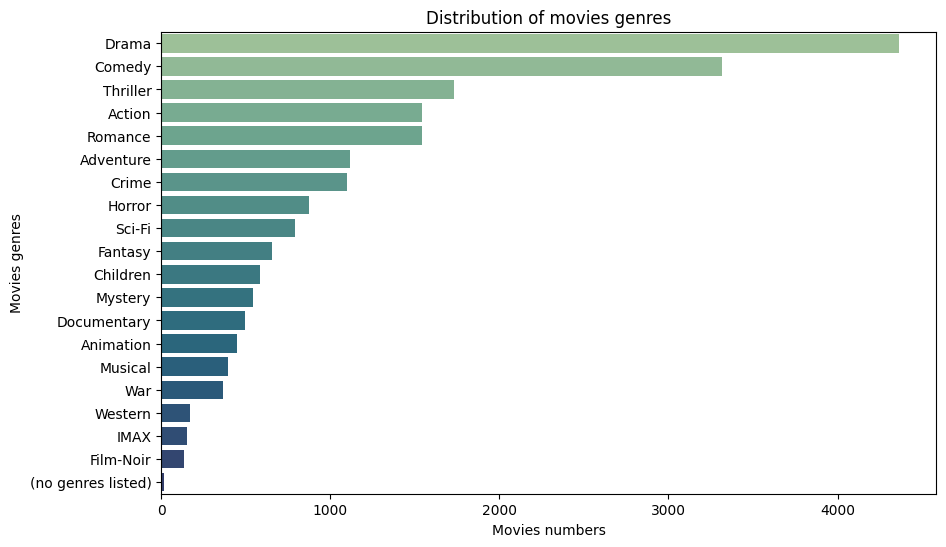

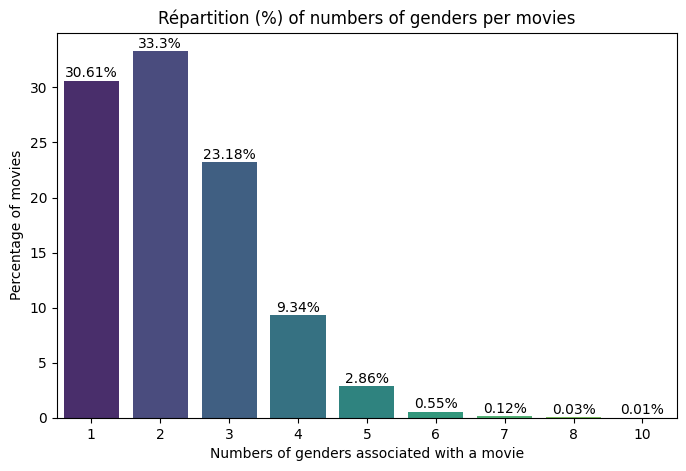

 Average numbers of genders per movie : 2.2290410958904108
 Maximum of genders for a movie : 10
Minimum of genders for a movie : 1


In [6]:
# Movies 
print ( "We have 9125 movies")
print (f"Number of duplicated movies :{movies_df.duplicated(subset = ['movieId', 'title', 'genres']).sum()}")
print (f"Number of missing values in the movies data :")
print (f"{movies_df.isnull().sum()}")
print("Distribution of the movies genres")
movies_df['genres_list'] = movies_df['genres'].apply(lambda x:x.split('|') if isinstance(x, str) else [])
genres_exploded =  movies_df.explode('genres_list')
genre_counts = genres_exploded['genres_list'].value_counts()

flat_genres = [genre for sublist in movies_df['genres_list'] for genre in sublist]
uniques_genre = set(flat_genres)
print(f"Total Numbers of genres : {len(uniques_genre)}")
# Numbers of movies for each genres
print(genre_counts)

# Visualization of the genres
genre_df = pd.DataFrame(genre_counts.items(), columns=['genre', 'count']).sort_values('count', ascending = False ) 
plt.figure(figsize = (10,6))
sns.barplot(y = 'genre', x = 'count', data = genre_df, palette = 'crest')
plt.title("Distribution of movies genres")
plt.xlabel("Movies numbers")
plt.ylabel("Movies genres")
plt.show


## Multigenders movies 
print ('='*20)
print ("Multigenders movies")
print ('='*20)
movies_df['n_genres'] = movies_df['genres_list'].apply(len)
dist = movies_df['n_genres'].value_counts().sort_values()
dist_percent = (dist / dist.sum() * 100).round(2)
dist_df = pd.DataFrame({
    'n_genres':dist.index,
    'percentage': dist_percent.values
}).sort_values('n_genres')
print(dist_df)
plt.figure(figsize=(8,5))
sns.barplot(x='n_genres', y = 'percentage', data = dist_df, palette = 'viridis')
plt.title("Répartition (%) of numbers of genders per movies")
plt.xlabel("Numbers of genders associated with a movie")
plt.ylabel("Percentage of movies")
# Adding of values on the bars
for idx, row in enumerate(dist_df.itertuples()):
    plt.text(idx, row.percentage + 0.3 , f"{row.percentage}%", ha = 'center')
plt.show()

print(" Average numbers of genders per movie :", movies_df['n_genres'].mean())
print(" Maximum of genders for a movie :", movies_df['n_genres'].max())
print("Minimum of genders for a movie :", movies_df['n_genres'].min())

          Users & Ratings
We have 100,004 ratings for 671 users
Numbers of missing values : userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
 Average numbers of ratings per user : 149.03725782414307
 Maximum of rating for a user : 2391
Minimum of rating for a user : 20
Median of rating for a user : 71.0
50% of users rated less than 71 movies and 50% of users rated more than 71 movies
Checking that each user rates a movie only once
Numbers of unique couple (userId, movieId) : 100004


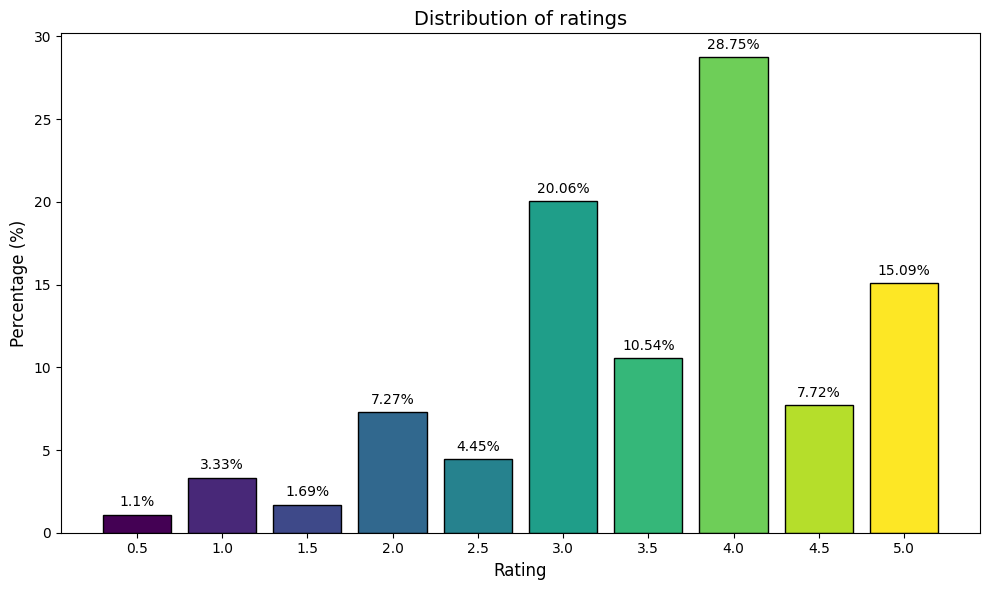

In [13]:
# Users & Ratings
print ('='*60)
print('          Users & Ratings')
print('='*60)
print ("We have 100,004 ratings for 671 users")

print(f"Numbers of missing values : {ratings_df.isnull().sum()}")

print(f" Average numbers of ratings per user : {ratings_df.groupby('userId')['rating'].count().mean()}")
print(" Maximum of rating for a user :", ratings_df.groupby('userId')['rating'].count().max())
print("Minimum of rating for a user :", ratings_df.groupby('userId')['rating'].count().min())
print("Median of rating for a user :", ratings_df.groupby('userId')['rating'].count().median())
print('50% of users rated less than 71 movies and 50% of users rated more than 71 movies')

# checking that the rating is unique for each user , each user rate a movie only once 
print("Checking that each user rates a movie only once")
unique_couples = ratings_df[['userId', 'movieId']].drop_duplicates().shape[0]
print(f"Numbers of unique couple (userId, movieId) : {unique_couples}")

# Distribution of ratings
rating_distribution = ratings_df['rating'].value_counts().sort_index()
rating_percent = ( rating_distribution / rating_distribution.sum() * 100 ).round(2)
rating_distribution_df = pd.DataFrame({
    'rating' :rating_distribution.index,
    'count': rating_distribution.values,
    'percentage': rating_percent.values
})
# # vizualisation
# plt.figure(figsize=(10,6))
# sns.barplot(x='rating', y = 'percentage', data = rating_distribution_df, hue = 'rating', palette='viridis', legend=False)
# plt.title("Distribution of ratings ")
# # Adding the percentage on the bar
# for idx, row in enumerate(rating_distribution_df.itertuples()):
#     plt.text(idx, row.count + 0.5, f"{row.percentage}%", ha='center')
# plt.show()


# vizualisation (alternative sans seaborn)
plt.figure(figsize=(10,6))
colors = plt.cm.viridis(np.linspace(0, 1, len(rating_distribution_df)))
plt.bar(rating_distribution_df['rating'].astype(str), rating_distribution_df['percentage'], color=colors, edgecolor='black')
plt.title("Distribution of ratings", fontsize=14)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)

# Adding the percentage on the bar
for idx, row in enumerate(rating_distribution_df.itertuples()):
    plt.text(idx, row.percentage + 0.5, f"{row.percentage}%", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

## 4. Loading Data into Neo4j

Now we will create the graph structure in Neo4j.

In [20]:
def clear_database():
    """Clear all nodes and relationships"""
    with driver.session() as session:
        session.run("MATCH (n) DETACH DELETE n")
    print("✓ Database cleared")

def create_constraints():
    """Create uniqueness constraints for better performance"""
    with driver.session() as session:
        try:
            session.run("CREATE CONSTRAINT user_id IF NOT EXISTS FOR (u:User) REQUIRE u.userId IS UNIQUE")
            session.run("CREATE CONSTRAINT movie_id IF NOT EXISTS FOR (m:Movie) REQUIRE m.movieId IS UNIQUE")
            print("✓ Constraints created")
        except Exception as e:
            print(f"Constraints may already exist: {e}")

# Clear and prepare database
clear_database()
create_constraints()

✓ Database cleared
✓ Constraints created


In [21]:
# Load movies
print("Loading movies...")
with driver.session() as session:
    for _, row in movies_df.iterrows():
        session.run("""
            MERGE (m:Movie {movieId: $movieId})
            SET m.title = $title, m.genres = $genres
        """, movieId=int(row['movieId']), 
             title=row['title'], 
             genres=row['genres'])

print(f"✓ Loaded {len(movies_df)} movies")

Loading movies...
✓ Loaded 9125 movies


In [22]:
# Load ratings in batches
print("Loading ratings...")
batch_size = 1000

for i in range(0, len(ratings_df), batch_size):
    batch = ratings_df.iloc[i:i+batch_size]
    
    with driver.session() as session:
        session.run("""
            UNWIND $ratings AS rating
            MERGE (u:User {userId: rating.userId})
            MERGE (m:Movie {movieId: rating.movieId})
            MERGE (u)-[r:RATED]->(m)
            SET r.rating = rating.rating, r.timestamp = rating.timestamp
        """, ratings=[row.to_dict() for _, row in batch.iterrows()])
    
    if (i + batch_size) % 10000 == 0:
        print(f"  Loaded {i + batch_size:,} ratings...")

print(f"✓ Loaded {len(ratings_df):,} ratings")
print("\n✓ Data loading complete!")

Loading ratings...
  Loaded 10,000 ratings...
  Loaded 20,000 ratings...
  Loaded 30,000 ratings...
  Loaded 40,000 ratings...
  Loaded 50,000 ratings...
  Loaded 60,000 ratings...
  Loaded 70,000 ratings...
  Loaded 80,000 ratings...
  Loaded 90,000 ratings...
  Loaded 100,000 ratings...
✓ Loaded 100,004 ratings

✓ Data loading complete!


In [23]:
# Verify data in Neo4j
with driver.session() as session:
    result = session.run("MATCH (u:User) RETURN count(u) AS count")
    user_count = result.single()["count"]
    
    result = session.run("MATCH (m:Movie) RETURN count(m) AS count")
    movie_count = result.single()["count"]
    
    result = session.run("MATCH ()-[r:RATED]->() RETURN count(r) AS count")
    rating_count = result.single()["count"]

print("="*60)
print("NEO4J DATABASE STATISTICS")
print("="*60)
print(f"Users in database: {user_count:,}")
print(f"Movies in database: {movie_count:,}")
print(f"Ratings in database: {rating_count:,}")
print("\n✓ Data successfully loaded into Neo4j!")

NEO4J DATABASE STATISTICS
Users in database: 671
Movies in database: 9,125
Ratings in database: 100,004

✓ Data successfully loaded into Neo4j!


In [24]:
# Try to get few data
with driver.session() as session:
    result = session.run("MATCH (n:Movie) RETURN n LIMIT 5")
    
    # Print the results
    for record in result:
        print(record["n"])

<Node element_id='4:ec60d456-54ff-49ac-8eab-6031537ac98a:0' labels=frozenset({'Movie'}) properties={'genres': 'Comedy|Crime|Thriller', 'movieId': 21, 'title': 'Get Shorty (1995)'}>
<Node element_id='4:ec60d456-54ff-49ac-8eab-6031537ac98a:1' labels=frozenset({'Movie'}) properties={'genres': 'Crime|Drama|Horror|Mystery|Thriller', 'movieId': 22, 'title': 'Copycat (1995)'}>
<Node element_id='4:ec60d456-54ff-49ac-8eab-6031537ac98a:2' labels=frozenset({'Movie'}) properties={'genres': 'Action|Crime|Thriller', 'movieId': 23, 'title': 'Assassins (1995)'}>
<Node element_id='4:ec60d456-54ff-49ac-8eab-6031537ac98a:3' labels=frozenset({'Movie'}) properties={'genres': 'Drama|Sci-Fi', 'movieId': 24, 'title': 'Powder (1995)'}>
<Node element_id='4:ec60d456-54ff-49ac-8eab-6031537ac98a:4' labels=frozenset({'Movie'}) properties={'genres': 'Drama|Romance', 'movieId': 25, 'title': 'Leaving Las Vegas (1995)'}>


In [25]:
# Try to get few data
with driver.session() as session:
    result = session.run("MATCH (n:Movie) RETURN n LIMIT 3")
    
    for record in result:
        movie = record["n"]
        print(f"Movie ID: {movie['movieId']}, Title: {movie['title']}")

Movie ID: 21, Title: Get Shorty (1995)
Movie ID: 22, Title: Copycat (1995)
Movie ID: 23, Title: Assassins (1995)


## 5. Recommandation System

### 5.1. The content-based approach

In [31]:
# Creating of Genre nodes and relationship

print("Creating Genders nodes and relationship ....")
with driver.session() as session :
    session.run( """
                MATCH(m:Movie)
                WHERE m.genres IS NOT NULL
                UNWIND split(m.genres, '|') AS genre
                MERGE (g:Genre{name:genre})
                MERGE (m)-[:HAS_GENRE]->(g)
                """)
print("Genres nodes and relationship created")

Creating Genders nodes and relationship ....
Genres nodes and relationship created


In [ ]:
def content_based (movie_title, limit = 10):
    """
    Recommend similar movies based on commons genders
    """
    
    with driver.session() as session:
        result = session.run("""
                              // step 1 : Find the reference movie
                              MATCH (m1:Movie {title: $title})
                              
                              // step 2 : Find his genders
                              MATCH (m1)-[:HAS_GENRE]->(g:Genre)
                              
                              // step 3 : Find others movies with the same genders
                              MATCH (m2:Movie)-[:HAS_GENRE]->(g)
                              
                              // step 4 : Exclude the original movie
                              WHERE m1 <> m2
                              
                              // step 5 : Count the genders they have in common and compute score
                              WITH m2, COUNT(DISTINCT g) AS common_genres, 
                                  COLLECT(DISTINCT g.name) AS shared_genres

                              // step 6 : Trier par similarité
                              RETURN m2.title AS recommended_movie, 
                                    m2.genres AS all_genres,
                                    common_genres AS similarity_score,
                                    shared_genres
                              ORDER BY similarity_score DESC
                              LIMIT $limit """, title = movie_title, limit = limit)
        recommendations = []
        for record in result:
            recommendations.append({
                'title':record['recommended_movie'], 
                'genres':record['all_genres'],
                'similarity_score': record['similarity_score'],
                'shared_genres': record['shared_genres']
            })
        return recommendations
    
    # Test
recommendations = content_based("Toy Story (1995)", limit=5)
print('='*60)
print(f"         Recommandations for user who like 'Toy Story (1995)'")
print('='*60)
for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec['title']}")
    print(f"   Similarity: {rec['similarity_score']} genres communs")
    print(f"   Genres partagés: {', '.join(rec['shared_genres'])}")
    print()

                                

         Recommandations pour 'Toy Story (1995)'
1. Asterix and the Vikings (Astérix et les Vikings) (2006)
   Similarité: 5 genres communs
   Genres partagés: Comedy, Children, Adventure, Fantasy, Animation

2. Shrek Forever After (a.k.a. Shrek: The Final Chapter) (2010)
   Similarité: 5 genres communs
   Genres partagés: Comedy, Children, Adventure, Fantasy, Animation

3. Turbo (2013)
   Similarité: 5 genres communs
   Genres partagés: Comedy, Children, Adventure, Fantasy, Animation

4. Antz (1998)
   Similarité: 5 genres communs
   Genres partagés: Comedy, Children, Adventure, Fantasy, Animation

5. Toy Story 2 (1999)
   Similarité: 5 genres communs
   Genres partagés: Comedy, Children, Adventure, Fantasy, Animation



### 5.2. The collaboratif filtering approach

The idea is to find the movies that a user rates good (rating >= 4). Then, Find others users that also like this movie. After, recommend movies those users like 

In [36]:
def collaboratif_filtering (user_id, limit = 10):
    """
    Recommend movies based on similar users are liked
    """
    with driver.session() as session:
        result = session.run("""
            // Step 1 : Movies that the user has liked
            MATCH (u:User {userId: $userId})-[r1:RATED]->(m:Movie)
            WHERE r1.rating >= 4.0
            
            // Step 2 : Others users that liked the same movie
            MATCH (u2:User)-[r2:RATED]->(m)
            WHERE u2 <> u AND r2.rating >= 4.0
            
            // Step 3 : Movies those similar users liked
            MATCH (u2)-[r3:RATED]->(m2:Movie)
            WHERE r3.rating >= 4.0
            
            // Step 4 : Exclurde the movie already watched
            AND NOT EXISTS((u)-[:RATED]->(m2))
            
            // Step 5 : Computing of a recommendation score
            WITH m2, 
                 COUNT(DISTINCT u2) AS users_who_liked,
                 AVG(r3.rating) AS avg_rating
            
            // Step 6 : Score composite
            RETURN m2.title AS recommended_movie,
                   m2.genres AS genres,
                   users_who_liked,
                   ROUND(avg_rating, 2) AS average_rating,
                   (users_who_liked * avg_rating) AS recommendation_score
            ORDER BY recommendation_score DESC
            LIMIT $limit
                    """, userId = user_id, limit = limit)
        
        recommendations = []
        for record in result:
            recommendations.append({
                'title' : record['recommended_movie'],
                'genres': record['genres'],
                'users_who_liked' : record['users_who_liked'],
                'avg_rating' : record['average_rating'],
                'score' : record['recommendation_score']
            })
        return recommendations
    
    # Test
user_recommendations = collaboratif_filtering(1, limit=5)
print('='*60)
print(f"        Recommendations for user 1")
print('='*60)
for i, rec in enumerate(user_recommendations, 1):
    print(f"{i}. {rec['title']}")
    print(f"   Score: {rec['score']:.1f}")
    print(f"   Liked by {rec['users_who_liked']} similar users")
    print(f"   Note moyenne: {rec['avg_rating']}")
    print()

        Recommendations for user 1
1. Star Wars: Episode V - The Empire Strikes Back (1980)
   Score: 221.7
   Liked by 49 similar users
   Note moyenne: 4.52

2. Star Wars: Episode IV - A New Hope (1977)
   Score: 217.2
   Liked by 47 similar users
   Note moyenne: 4.62

3. Godfather, The (1972)
   Score: 206.7
   Liked by 43 similar users
   Note moyenne: 4.81

4. Pulp Fiction (1994)
   Score: 202.3
   Liked by 43 similar users
   Note moyenne: 4.71

5. Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
   Score: 199.6
   Liked by 44 similar users
   Note moyenne: 4.54



### 5.3. Hybride approach (Content + collaboratif )

In [ ]:
def recommend_hybrid(user_id, movie_title=None, limit=10):
    """
    Combine both approach for best recommendations
    """
    with driver.session() as session:
        result = session.run("""
            // Step 1 : Films de l'utilisateur bien notés
            MATCH (u:User {userId: $userId})-[r:RATED]->(liked:Movie)
            WHERE r.rating >= 4.0
            
            // Step 2 : Genres de ces films
            MATCH (liked)-[:HAS_GENRE]->(g:Genre)
            
            // Step 3 : Similar movies by gender
            MATCH (recommended:Movie)-[:HAS_GENRE]->(g)
            WHERE NOT EXISTS((u)-[:RATED]->(recommended))
            
            // Step 4 : Others users that liked similar movies
            OPTIONAL MATCH (u2:User)-[r2:RATED]->(recommended)
            WHERE u2 <> u AND r2.rating >= 4.0
            
            // Step 5 : Computing of scores
            WITH recommended,
                 COUNT(DISTINCT g) AS genre_match,
                 COUNT(DISTINCT u2) AS collaborative_score,
                 AVG(r2.rating) AS avg_rating
            
            // Step 6 : Hybrid score
            RETURN recommended.title AS title,
                   recommended.genres AS genres,
                   genre_match,
                   collaborative_score,
                   COALESCE(avg_rating, 0) AS avg_rating,
                   (genre_match * 2 + collaborative_score + COALESCE(avg_rating, 0)) AS hybrid_score
            ORDER BY hybrid_score DESC
            LIMIT $limit
        """, userId=user_id, limit=limit)
        
        recommendations = []
        for record in result:
            recommendations.append({
                'title': record['title'],
                'genres': record['genres'],
                'genre_match': record['genre_match'],
                'collaborative_score': record['collaborative_score'],
                'avg_rating': record['avg_rating'],
                'hybrid_score': record['hybrid_score']
            })
        
        return recommendations

# Test
hybrid_recs = recommend_hybrid(1, limit=5)
print('='*60)
print(f"       Hybrid recommendations for user 1 ")
print('='*60)
for i, rec in enumerate(hybrid_recs, 1):
    print(f"{i}. {rec['title']}")
    print(f"   Hybrid score: {rec['hybrid_score']:.1f}")
    print(f"   Commons genders : {rec['genre_match']}")
    print(f"   Score collaboratif: {rec['collaborative_score']}")
    print()